In [13]:
### IMPORT LIBRARIES ###
import magpy as mp
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

expt_path = "/proj/magness/CDS010-014-015_combined"
sc.set_figure_params(dpi_save = 300, format = 'svg')
fig_path = expt_path+'fig8_BEST4s/'
sc.settings.figdir = fig_path

plt.rcParams ['figure.facecolor'] = 'white'

In [3]:
### PEARSON CORRELATION FUNCTION ###
import scipy.stats as stats
import pandas as pd
from scipy.stats import rankdata

def bh_correct(pvals):
    ranked_pvals = rankdata(pvals)
    adjusted_pvals = (pvals * len(pvals)) / ranked_pvals
    adjusted_pvals[adjusted_pvals>1] = 1
    return(adjusted_pvals)

def test_correlation(subset1, gene1, subset2, gene2=None):
    
    #Get list of donor_regions
    regions = subset1.obs.donor_region.unique().tolist()
    
    #Initialize matrices
    X = np.zeros(len(regions))
    if gene2: Y = np.zeros(len(regions))
    else: Y = np.zeros((subset2.shape[1],len(regions)))

    #Calcualte means
    for i,region in enumerate(regions):
        X[i] = subset1[subset1.obs.donor_region==region,gene1].layers['raw_normalized'].toarray().mean()
        if gene2: Y[i] = subset2[subset2.obs.donor_region==region,gene2].layers['raw_normalized'].toarray().mean()
        else: Y[:,i] = subset2[subset2.obs.donor_region==region,:].layers['raw_normalized'].toarray().mean(axis=0)
    
    #Calculate Pearson coefficient(s)
    if gene2:
        r_val,p_val = stats.pearsonr(X, Y)
        mean = Y.mean()
        stdev = Y.std()
        results = pd.Series([r_val,p_val,mean,stdev],index=['r_val','p_val','mean','stdev'])
        return results
    else:
        r_vals = np.zeros(Y.shape[0])
        p_vals = np.zeros(Y.shape[0])
        means = np.zeros(Y.shape[0])
        stdevs = np.zeros(Y.shape[0])
        for j in range(Y.shape[0]):
            r,p = stats.pearsonr(X, Y[j])
            r_vals[j] = r
            p_vals[j] = p
            means[j] = Y[j].mean()
            stdevs[j] = Y[j].std()
        results = pd.DataFrame({'r_val':r_vals, 'p_val':p_vals, 'mean':means, 'stdev':stdevs}, index=subset2.var.index)
        return results.sort_values(by='r_val',ascending=False)

Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad



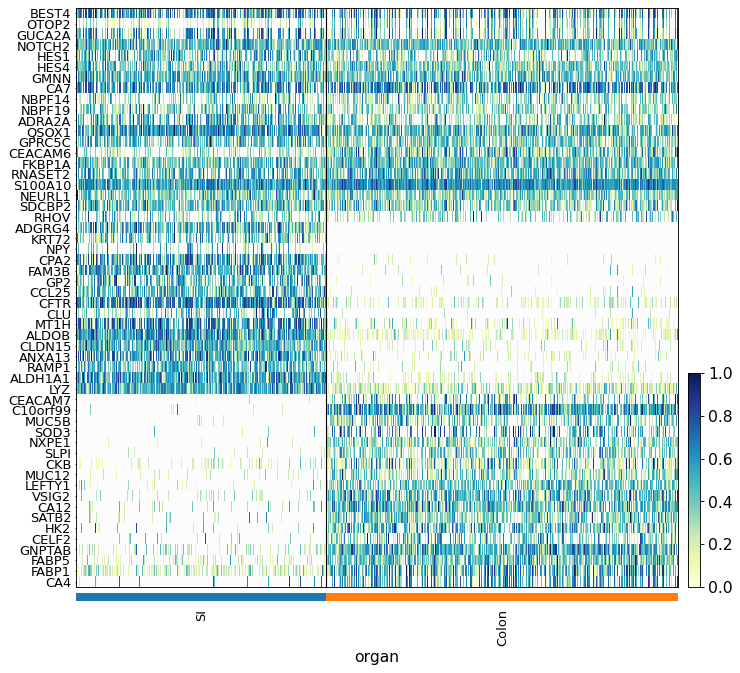

In [6]:
### PANEL A - Heatmap of differences between SI and Colon ###

#Load and subset data
adata = mp.load(expt_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")
subset = adata[adata.obs['type']=='BEST4']

#Gene lists
shared_genes = ['BEST4','OTOP2','GUCA2A','NOTCH2','HES1','HES4','GMNN','CA7','NBPF14','NBPF19','ADRA2A','QSOX1',
                'GPRC5C','CEACAM6','FKBP1A','RNASET2','S100A10','NEURL1','SDCBP2','RHOV']

si_genes = ['ADGRG4','KRT72','NPY','CPA2','FAM3B','GP2','CCL25','CFTR','CLU','MT1H','ALDOB',
            'CLDN15','ANXA13','RAMP1','ALDH1A1','LYZ']

c_genes = ['CEACAM7','C10orf99','MUC5B','SOD3','NXPE1','SLPI','CKB','MUC12','LEFTY1','VSIG2',
           'CA12','SATB2','HK2','CELF2','GNPTAB','FABP5','FABP1','CA4']

all_genes =  shared_genes+si_genes+c_genes

#Plotting
subset.obs.organ.cat.reorder_categories(['SI','Colon'],inplace=True)

sc.pl.heatmap(subset, all_genes, groupby='organ', #save="_colon-v-SI-markers.svg",
                  swap_axes=True, show_gene_labels=True, standard_scale='var',cmap=mp.blues)

# sc.pl.dotplot(adata, shared_genes, groupby='lineage',swap_axes=True, standard_scale='var')

Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.42.h5ad



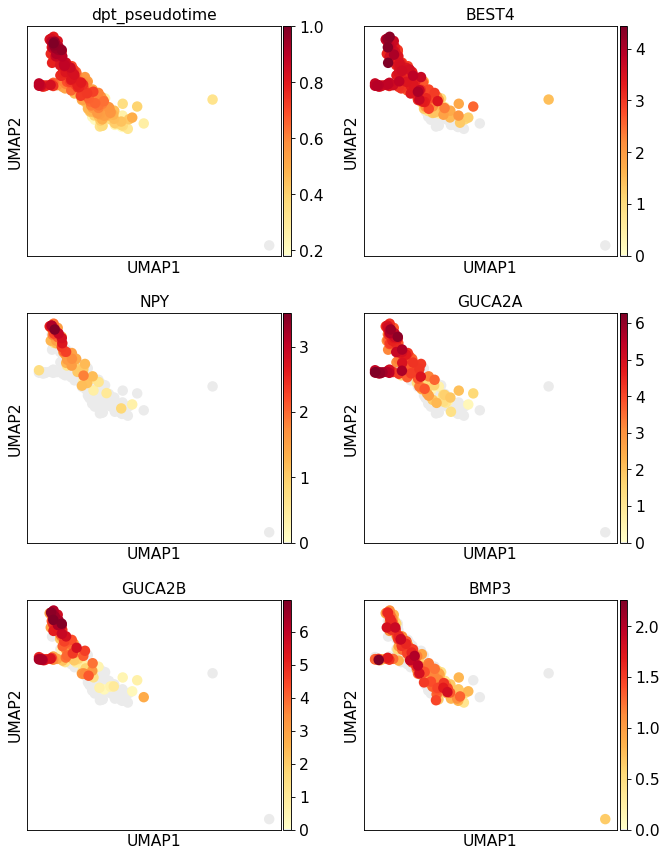

In [10]:
### PANEL B,F - PSEUDOTIME EXPRESSION ###
adata = mp.load(expt_path, "clustered_annotated_adata_k25_lr0.92_v1.42.h5ad")

sc.pl.umap(adata[adata.obs.lineage=='SI_BEST4'],color=['dpt_pseudotime','BEST4','NPY','GUCA2A','GUCA2B','BMP3'],
           cmap=mp.reds,ncols=2)#, save='_NPY-GUC-pseudotime_v2.svg')

Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad



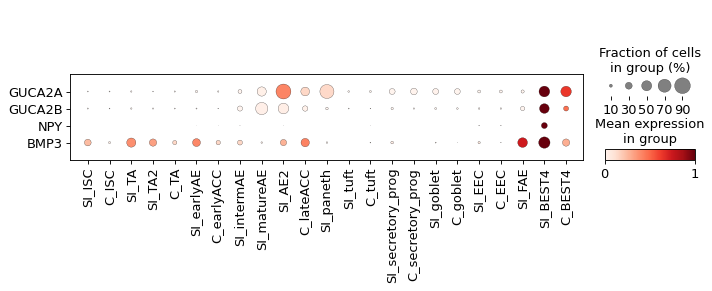

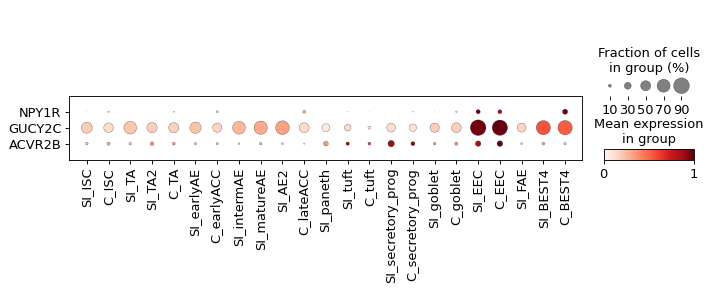

In [11]:
### PANEL E - GUC and NPY Expression ###

adata = mp.load(expt_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")
adata = mp.scale_adata(adata,groupby='lineage')

sc.pl.dotplot(adata,['GUCA2A','GUCA2B','NPY','BMP3'],groupby='lineage',swap_axes=True,layer='raw_scaled')#,save="_NPY-GUC_v2.svg")
sc.pl.dotplot(adata,['NPY1R','GUCY2C','ACVR2B'],groupby='lineage',swap_axes=True,layer='raw_scaled')#,save="_NPY-GUC-BMP.svg")

Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad

SI BEST4


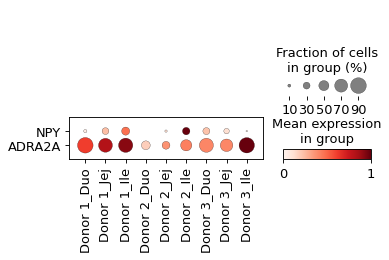

All SI absorptive


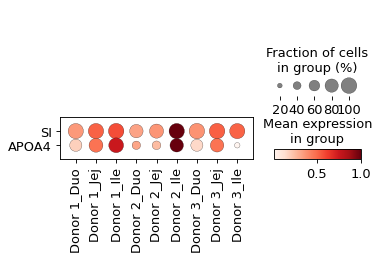

In [12]:
### PANEL G - CORRELATION ANALYSIS ###

adata = mp.load(expt_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")
    
#Reorder donor-region to be more interpretable
donor_regions = []
for i in [1,2,3]:
    donor_regions = donor_regions + [f'Donor {i}_Duo',f'Donor {i}_Jej',f'Donor {i}_Ile']

print("SI BEST4")
subset = adata[adata.obs.lineage=='SI_BEST4']
subset.obs['donor_region'].cat.reorder_categories(donor_regions,inplace=True)
subset = mp.scale_adata(subset, groupby='donor_region', layer='raw_scaled')
sc.pl.dotplot(subset,['NPY','ADRA2A'],groupby='donor_region',swap_axes=True,layer='raw_scaled')#, save='_NPY-by-donor_v2.svg')

print("All SI absorptive")
subset = adata[(adata.obs.type=='absorptive') & (adata.obs.organ=='SI')]
subset.obs['donor_region'].cat.reorder_categories(donor_regions,inplace=True)
subset = mp.scale_adata(subset, groupby='donor_region', layer='raw_scaled')
sc.pl.dotplot(subset,['SI','APOA4'],groupby='donor_region',swap_axes=True,layer='raw_scaled')#,save='_SI-APOv2.svg')

Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad



Trying to set attribute `.var` of view, copying.


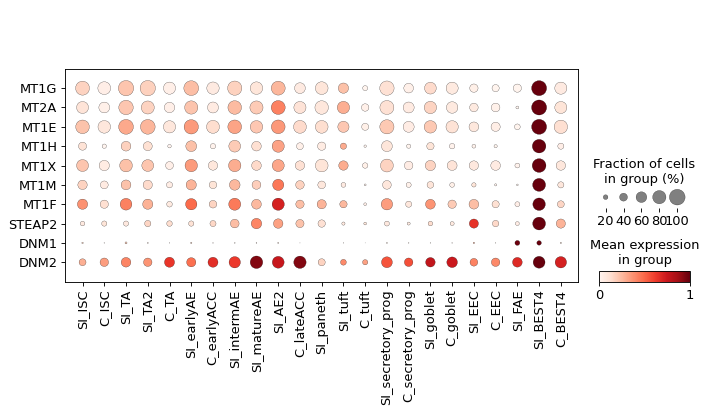

In [8]:
### PANEL F - Metal Binding and Dynamins ###
adata = mp.load(expt_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")

gene_list = ['MT1E','MT1F','MT1G','MT1H','MT1M','MT1X','MT2A','STEAP2']
gene_list = mp.sort_list_by_mean(adata,gene_list) + ['DNM1','DNM2']

adata = mp.scale_adata(adata)
sc.pl.dotplot(adata, gene_list, groupby='lineage', swap_axes=True, layer='raw_scaled')#,save="_metal_v2.svg")
